### Chroma multimodal: https://docs.trychroma.com/guides/multimodal 

In [ ]:
# %pip install --upgrade chromadb
# %pip install pillow
# %pip install open-clip-torch
# %pip install tqdm
# %pip install matplotlib
# %pip install pandas
# %pip install langchain_openai


In [1]:
import os
import json
import chromadb 
import pandas as pd
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction 
from chromadb.utils.data_loaders import ImageLoader
from matplotlib import pyplot as plt 
from langchain_openai import ChatOpenAI

In [15]:
class ImageEmbeddingAgent:
    def __init__(self) -> None:
        self.gpt_model = ChatOpenAI(model="gpt-3.5-turbo-0125")

        chroma_client = chromadb.PersistentClient(path='chroma_vectordb')
        image_loader = ImageLoader()
        multimodal_ef = OpenCLIPEmbeddingFunction()

        self.kitchen_collection = chroma_client.get_or_create_collection(name="kitchen_view", embedding_function=multimodal_ef, data_loader=image_loader)
        self.bathroom_collection = chroma_client.get_or_create_collection(name="bathroom_view", embedding_function=multimodal_ef, data_loader=image_loader)
        self.bedroom_collection = chroma_client.get_or_create_collection(name="bedroom_view", embedding_function=multimodal_ef, data_loader=image_loader)
        self.frontal_collection = chroma_client.get_or_create_collection(name="frontal_view", embedding_function=multimodal_ef, data_loader=image_loader)

        self.load_information()
        self.add_or_update_collection(self.kitchen_collection, self.ids, self.kitchen_uris, self.metadatas)
        self.add_or_update_collection(self.bathroom_collection, self.ids, self.bathroom_uris, self.metadatas)
        self.add_or_update_collection(self.bedroom_collection, self.ids, self.bedroom_uris, self.metadatas)      
        self.add_or_update_collection(self.frontal_collection, self.ids, self.frontal_uris, self.metadatas)
        # print(self.frontal_collection.count())  


    def load_information(self):
        column_names = ['num_bedrooms', 'num_bathrooms', 'area', 'zipcode', 'price']
        df = pd.read_csv('./houses_dataset/Houses Dataset/HousesInfo.txt', delimiter=' ', header=None, names=column_names)
        # print(df.head(5))

        total_num_houses = len(df)

        self.ids = []
        self.kitchen_uris = []
        self.bathroom_uris = []
        self.bedroom_uris = []
        self.frontal_uris = []
        self.metadatas = []

        for i in range(total_num_houses):
            self.ids.append(str(i))

            path = f'houses_dataset/Houses Dataset/{i+1}'
            self.kitchen_uris.append(f'{path}_kitchen.jpg')    
            self.bathroom_uris.append(f'{path}_bathroom.jpg')
            self.bedroom_uris.append(f'{path}_bedroom.jpg')
            self.frontal_uris.append(f'{path}_frontal.jpg')

            self.metadatas.append(
                    {
                        'number_of_bedrooms': int(df.iloc[i, 0]), 
                        'number_of_bathrooms': int(df.iloc[i, 1]), 
                        'area': int(df.iloc[i, 2]),
                        'zipcode': int(df.iloc[i, 3]),
                        'price': int(df.iloc[i, 4])
                    }        
            )        

        # print(self.ids[:5])
        # print(self.frontal_uris[:5])
        # print(self.metadatas[:5])


    def add_or_update_collection(self, collection, ids, uris, metadatas):      # add: to add first time, update: to update
        # collection.add(                                         
        #     ids=ids,
        #     uris=uris,
        #     metadatas=metadatas
        # )

        collection.update(
            ids=ids,
            uris=uris,
            metadatas=metadatas
        )


    def _get_weights(self, query):
        template = (
                "I have four different pictures of a house: the internal picture of the kitchen, internal picture of a bathroom, internal picture of a bedroom, and frontal view of house. "
                "Which pictures are more relevant for this query: " + query + 
                " Please provide the result only in json format with the weight of each picture type. The summation of the weights should be 1. Use keywords only: kitchen, bathroom, bedroom, frontal"
            )

        res = self.gpt_model.invoke(template)
        res_str = res.content if hasattr(res, 'content') else str(res)
        weights = json.loads(res_str)
        return weights        


    def print_query_results(self, query_list: list, query_results: dict)->None:
        result_count = len(query_results['ids'][0])

        for i in range(len(query_list)):
            print(f'Results for query: {query_list[i]}')

            for j in range(result_count):
                id       = query_results["ids"][i][j]
                distance = query_results['distances'][i][j]
                data     = query_results['data'][i][j]
                document = query_results['documents'][i][j]
                metadata = query_results['metadatas'][i][j]
                uri      = query_results['uris'][i][j]

                print(f'id: {id}, distance: {distance}, metadata: {metadata}, document: {document}') 
                print(f'data: {uri}')
                plt.imshow(data)
                plt.axis("off")
                plt.show()


    def multimodal_query(self, multimodal_db, query_texts, ids, num_top_houses):
        query_results = multimodal_db.query(
            query_texts=query_texts,
            n_results=num_top_houses, 
            include=['documents', 'distances', 'metadatas', 'data', 'uris'],
            # where={'id': {'$in': ids}}
            # where={'$and': [
            #     {'price': {'$gt': price - bound_range}},
            #     {'price': {'$lt': price + bound_range}},
            #     {'number_of_bedrooms': {'$eq': num_bedroom}}
            # ]
        # }                                                                  # Options: $eq, $ne, $gt, $gte, $lt, $lte
        )
        return query_results


    def filter_houses(self, query, ids, num_top_houses=10):
        weights = self._get_weights(query)
        print("query:", query)
        print("weights:", weights)
        queries = [query]

        max_key = max(weights, key=weights.get)
        print("using key:", max_key)

        if max_key == 'kitchen':
            result = self.multimodal_query(self.kitchen_collection, queries, ids, num_top_houses)
        elif max_key == 'bathroom':
            result = self.multimodal_query(self.bathroom_collection, queries, ids, num_top_houses)
        elif max_key == 'bedroom':
            result = self.multimodal_query(self.bedroom_collection, queries, ids, num_top_houses)
        else:
            result = self.multimodal_query(self.frontal_collection, queries, ids, num_top_houses)

        self.print_query_results(queries, result)
        return result['ids'][0]
        

query: Find good houses
weights: {'kitchen': 0.1, 'bathroom': 0.1, 'bedroom': 0.1, 'frontal': 0.7}
using key: frontal
Results for query: Find good houses
id: 112, distance: 1.5610837936401367, metadata: {'area': 3778, 'number_of_bathrooms': 3, 'number_of_bedrooms': 5, 'price': 949000, 'zipcode': 91901}, document: None
data: houses_dataset/Houses Dataset/113_frontal.jpg


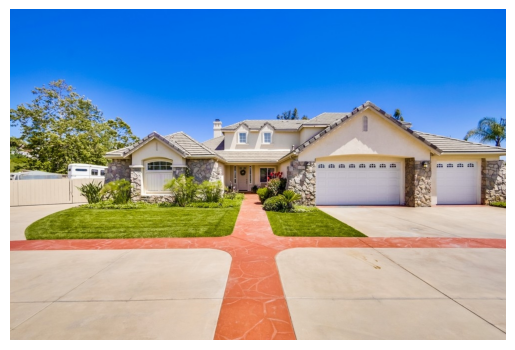

id: 204, distance: 1.564746618270874, metadata: {'area': 1110, 'number_of_bathrooms': 1, 'number_of_bedrooms': 2, 'price': 649000, 'zipcode': 94501}, document: None
data: houses_dataset/Houses Dataset/205_frontal.jpg


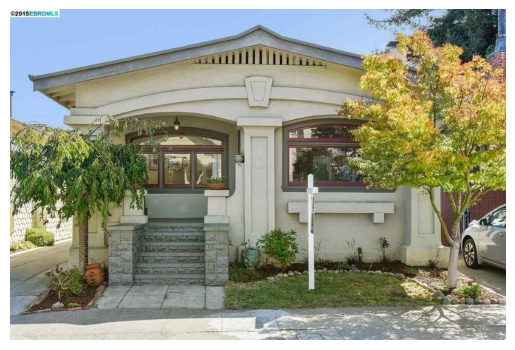

['112', '204']


In [16]:
if __name__ == "__main__":
    os.environ["OPENAI_API_KEY"] = 'sk-proj-YsE5dZkWvxqa3dJpGRhZT3BlbkFJ2zQSyvln9eq6cKEf2dau'  # getpass.getpass()

    agent = ImageEmbeddingAgent()

    # query = 'Find houses in the hilly area'
    query = 'Find good houses'

    ids = [1, 5, 10, 14, 15]
    res = agent.filter_houses(query, ids, 2)
    print(res)